In [ ]:
!pip3 install langchain openai tiktoken transformers nltk

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from sentence_transformers import SentenceTransformer, util
# import torch
# import mplcursors
from umap import UMAP
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
import json
from langchain.chains.summarize import load_summarize_chain
from langchain.chat_models import ChatOpenAI
from langchain.prompts import PromptTemplate
import tiktoken
from langchain.docstore.document import Document
from langchain.text_splitter import CharacterTextSplitter


import textwrap
from time import monotonic

from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', '00', 'no2', 'no3'])

# Data

### Data Loadind & Preprocessing

In [54]:
df = pd.read_json('./raw_data/waterloo_ai.abstracts.json')

df.head()

authorID                                       publications  \
0  T4wUsIMAAAAJ  [{'title': 'TARDBP mutations in individuals wi...   
1  LAWKnMgAAAAJ  [{'title': 'Optimal dynamic reinsurance polici...   
2  kQBCvYEAAAAJ  [{'title': 'Wireless sensor network localizati...   
3  xqRH0KMAAAAJ  [{'title': '30 years of lithium‐ion batteries'...   
4  eMNK__gAAAAJ  [{'title': 'Efficient beam propagation techniq...   

                                publications_pubdate  
0  [{'title': 'Vero cells gain renal tubule marke...  
1  [{'title': 'Relative growth rate optimization ...  
2  [{'title': 'Global solution to sensor network ...  
3  [{'title': 'Investigation of NiCoOx catalysts ...  
4  [{'title': 'Branched Variational Autoencoder C...

In [55]:
faculty_df = pd.read_excel('./raw_data/Waterloo_AI_Faculty_Email_List_edited.xlsx')

# remove unnamed columns
faculty_df = faculty_df.loc[:, ~faculty_df.columns.str.contains('^Unnamed')]

# change column name of the gs_author_id to the author_id
faculty_df.rename(columns={'gs_author_id': 'author_id'}, inplace=True)


with open('data/all_data.json', 'r') as file:
    papers_data = json.load(file)



faculty_df.head()

email first_name   last_name       faculty  \
0  ladan.tahvildari@uwaterloo.ca      Ladan  Tahvildari   Engineering   
1          gckamath@uwaterloo.ca    Guatam       Kamath  Mathematics    
2          vcgaudet@uwaterloo.ca   Vinvent       Gaudet   Engineering   
3    apurva.narayan@uwaterloo.ca     Apruva      Naryan   Engineering   
4         gvcormack@uwaterloo.ca     Gordon     Cormack  Mathematics    

                             department  \
0   Electrical and Computer Engineering   
1  Cheriton School of computer science    
2   Electrical and Computer Engineering   
3            Systems Design Engineering   
4  Cheriton School of computer science    

                                       area_of_focus  \
0         software architecture, autonomic computing   
1  privacy, robustness, machine learning, and sta...   
2  High performance microsystems for information ...   
3            AI, machine learning, and deep learning   
4                   High stakes information retrival   

                                             gs_link     author_id  
0  https://scholar.google.ca/citations?user=zJ4HJ...  zJ4HJb4AAAAJ  
1  https://scholar.google.com/citations?user=MK6z...  MK6zHkYAAAAJ  
2  https://scholar.google.ca/citations?user=niKoL...  niKoLAYAAAAJ  
3  https://scholar.google.ca/citations?user=e5OCZ...  e5OCZ1cAAAAJ  
4  https://scholar.google.com/citations?user=wFuZ...  wFuZKaUAAAAJ

In [80]:
rows = []
row_update = []

# 'authorID', 'publications', 'publications_pubdate'
for faculty in papers_data:
    author_id = faculty['authorID']

    # publications is a list of top cited papers
    publications = faculty['publications']

    for publication in publications:
        title = publication['title']
        abstract = publication['abstract']
        doi = publication['doi']
        gs_url = publication['gs_url']

        rows.append({
            'author_id': author_id,
            'title': title,
            'abstract': abstract,
            'doi': doi,
            'gs_url': gs_url
        })


    # publications_pubdate is a list of most recent papers
    publications_pubdate = faculty['publications_pubdate']

    for publication in publications_pubdate:
        title = publication['title']
        abstract = publication['abstract']
        doi = publication['doi']
        gs_url = publication['gs_url']

        row_update.append({
            'author_id': author_id,
            'title': title,
            'abstract': abstract,
            'doi': doi,
            'gs_url': gs_url
        })


publications_df = pd.DataFrame(rows)
publications_pubdate_df = pd.DataFrame(row_update)


publications_df.head()

{'title': 'TARDBP mutations in individuals with sporadic and familial amyotrophic lateral sclerosis', 'gs_url': 'https://scholar.google.com/citations?view_op=view_citation&hl=en&user=T4wUsIMAAAAJ&citation_for_view=T4wUsIMAAAAJ:u5HHmVD_uO8C', 'abstract': None, 'doi': 'https://doi.org/10.1038/ng.132'}
{'title': 'Promotion of plant growth by bacterial ACC deaminase', 'gs_url': 'https://scholar.google.com/citations?view_op=view_citation&hl=en&user=T4wUsIMAAAAJ&citation_for_view=T4wUsIMAAAAJ:qjMakFHDy7sC', 'abstract': 'To date, there has been only limited commercial use of plant growth-promoting bacteria in agriculture, horticulture, and silviculture. However, with recent progress toward understanding the mechanisms that these organisms utilize to facilitate plant growth, the use of plant growth-promoting bacteria is expected to continue to increase worldwide. One of the key mechanisms employed by plant growth-promoting bacteria to facilitate plant growth is the lowering of plant ethylene l

author_id                                              title  \
0  T4wUsIMAAAAJ  TARDBP mutations in individuals with sporadic ...   
1  T4wUsIMAAAAJ  Promotion of plant growth by bacterial ACC dea...   
2  T4wUsIMAAAAJ  The performance of current methods in ligand–p...   
3  T4wUsIMAAAAJ  New insights into 1-aminocyclopropane-1-carbox...   
4  T4wUsIMAAAAJ  Toxicity of a pah photooxidation product to th...   

                                            abstract  \
0                                               None   
1  To date, there has been only limited commercia...   
2                                               None   
3                                               None   
4                                               None   

                                                 doi  \
0                     https://doi.org/10.1038/ng.132   
1          https://doi.org/10.1080/07352680701572966   
2                                               None   
3                                               None   
4  https://doi.org/10.1897/1551-5028(1997)016<089...   

                                              gs_url  
0  https://scholar.google.com/citations?view_op=v...  
1  https://scholar.google.com/citations?view_op=v...  
2  https://scholar.google.com/citations?view_op=v...  
3  https://scholar.google.com/citations?view_op=v...  
4  https://scholar.google.com/citations?view_op=v...

In [58]:
# Merging the faculty dataframe with the publications dataframe
combined_df = pd.merge(faculty_df, publications_df, left_on='author_id', right_on='author_id')

combined_df_pubdate = pd.merge(faculty_df, publications_pubdate_df, left_on='author_id', right_on='author_id')

combined_df.head()

email first_name   last_name      faculty  \
0  ladan.tahvildari@uwaterloo.ca      Ladan  Tahvildari  Engineering   
1  ladan.tahvildari@uwaterloo.ca      Ladan  Tahvildari  Engineering   
2  ladan.tahvildari@uwaterloo.ca      Ladan  Tahvildari  Engineering   
3  ladan.tahvildari@uwaterloo.ca      Ladan  Tahvildari  Engineering   
4  ladan.tahvildari@uwaterloo.ca      Ladan  Tahvildari  Engineering   

                            department  \
0  Electrical and Computer Engineering   
1  Electrical and Computer Engineering   
2  Electrical and Computer Engineering   
3  Electrical and Computer Engineering   
4  Electrical and Computer Engineering   

                                area_of_focus  \
0  software architecture, autonomic computing   
1  software architecture, autonomic computing   
2  software architecture, autonomic computing   
3  software architecture, autonomic computing   
4  software architecture, autonomic computing   

                                             gs_link     author_id  \
0  https://scholar.google.ca/citations?user=zJ4HJ...  zJ4HJb4AAAAJ   
1  https://scholar.google.ca/citations?user=zJ4HJ...  zJ4HJb4AAAAJ   
2  https://scholar.google.ca/citations?user=zJ4HJ...  zJ4HJb4AAAAJ   
3  https://scholar.google.ca/citations?user=zJ4HJ...  zJ4HJb4AAAAJ   
4  https://scholar.google.ca/citations?user=zJ4HJ...  zJ4HJb4AAAAJ   

                                               title  \
0  Software engineering for self-adaptive systems...   
1  Self-adaptive software: Landscape and research...   
2  The effects of time constraints on test case p...   
3  Autonomic computing: emerging trends and open ...   
4    Cloud computing uncovered: a research landscape   

                                            abstract  \
0  The goal of this roadmap paper is to summarize...   
1                                               None   
2  Regression testing is an expensive process use...   
3                                               None   
4  The amalgamation of technology and service-bas...   

                                                 doi  \
0        https://doi.org/10.1007/978-3-642-35813-5_1   
1                                               None   
2                https://doi.org/10.1109/tse.2010.58   
3                                               None   
4  https://doi.org/10.1016/b978-0-12-396535-6.000...   

                                              gs_url  
0  https://scholar.google.com/citations?view_op=v...  
1  https://scholar.google.com/citations?view_op=v...  
2  https://scholar.google.com/citations?view_op=v...  
3  https://scholar.google.com/citations?view_op=v...  
4  https://scholar.google.com/citations?view_op=v...

In [59]:
# remove if abstract is None
combined_df = combined_df[combined_df['abstract'].notna()]
combined_df_pubdate = combined_df_pubdate[combined_df_pubdate['abstract'].notna()]

# remove if abstract is empty string
combined_df = combined_df[combined_df['abstract'] != '']
combined_df_pubdate = combined_df_pubdate[combined_df_pubdate['abstract'] != '']

### Vector Embedding

In [60]:
# Load the pre-trained embedding model
model = SentenceTransformer('all-MiniLM-L6-v2')

# Encode all 25k reviews
BATCH_SIZE = 128
embeddings = model.encode(combined_df['abstract'].values.tolist(), batch_size=BATCH_SIZE, show_progress_bar=True)

Batches:   0%|          | 0/23 [00:00<?, ?it/s]

In [61]:
embeddings_pubdate = model.encode(combined_df_pubdate['abstract'].values.tolist(), batch_size=BATCH_SIZE, show_progress_bar=True)

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

In [62]:
# save embeddings to df
combined_df['embeddings'] = embeddings.tolist()
combined_df_pubdate['embeddings'] = embeddings_pubdate.tolist()

combined_df.sample(1)

email first_name last_name  faculty department  \
3003  rodsmith@uwaterloo.ca     Rodney     Smith  Science  Chemistry   

                                          area_of_focus  \
3003  Microplastics, Environmental impacts, Distribu...   

                                                gs_link     author_id  \
3003  https://scholar.google.ca/citations?user=FjHID...  FjHIDkAAAAAJ   

                                                  title  \
3003  Structural and functional role of anions in el...   

                                               abstract  \
3003  Arsenate ions are incorporated in amorphous co...   

                                     doi  \
3003  https://doi.org/10.1039/c9cp01754b   

                                                 gs_url  \
3003  https://scholar.google.com/citations?view_op=v...   

                                             embeddings  
3003  [0.037832558155059814, -0.03902418166399002, -...

### Reduce Dimensionality of Data using UMAP

In [63]:
# reduce dimensionality of embeddings
umap = UMAP(n_components=2)
umap_embeddings = umap.fit_transform(embeddings)
combined_df['umap_x'] = umap_embeddings[:, 0]
combined_df['umap_y'] = umap_embeddings[:, 1]


umap = UMAP(n_components=2)
umap_embeddings_pubdate = umap.fit_transform(embeddings_pubdate)
combined_df_pubdate['umap_x'] = umap_embeddings_pubdate[:, 0]
combined_df_pubdate['umap_y'] = umap_embeddings_pubdate[:, 1]


# cluster embeddings
num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings)
cluster_assignment = clustering_model.labels_
combined_df['cluster'] = cluster_assignment

num_clusters = 10
clustering_model = KMeans(n_clusters=num_clusters)
clustering_model.fit(embeddings_pubdate)
cluster_assignment = clustering_model.labels_
combined_df_pubdate['cluster'] = cluster_assignment

In [64]:
# KernelDensity
x = combined_df['umap_x'].values
y = combined_df['umap_y'].values
xy = np.vstack([x,y])
z = np.zeros_like(x)
z = z.reshape(-1, 1)
xy = xy.reshape(-1, 2)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(xy)
z = kde.score_samples(xy)
z = z.reshape(-1, 1)
combined_df['kde'] = z


x = combined_df_pubdate['umap_x'].values
y = combined_df_pubdate['umap_y'].values
xy = np.vstack([x,y])
z = np.zeros_like(x)
z = z.reshape(-1, 1)
xy = xy.reshape(-1, 2)
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(xy)
z = kde.score_samples(xy)
z = z.reshape(-1, 1)
combined_df_pubdate['kde'] = z

### Extract Top Keywords from Clustered Documents

In [65]:
tfidf_vectorizer = TfidfVectorizer(stop_words="english").fit(combined_df['abstract'].values.tolist())
tfidf_vectors = tfidf_vectorizer.transform(combined_df['abstract'].values.tolist())
tfidf_matrix = tfidf_vectors.toarray()

# Get the top 10 keywords for each cluster in the dict
top_keywords = {}
for cluster in range(num_clusters):
    top_keywords[cluster] = [tfidf_vectorizer.get_feature_names_out()[i] for i in tfidf_matrix[cluster].argsort()[-5:][::-1]]

for i, keywords in top_keywords.items():
    print(f"Cluster {i}:", keywords)



top_keywords_str = {}
for i, keywords in top_keywords.items():
    top_keywords_str[i] = ', '.join(keywords)

combined_df['top_keywords'] = combined_df['cluster'].map(top_keywords_str)


#  ===== combined_df_pubdate
tfidf_vectorizer_pubdate = TfidfVectorizer(stop_words="english").fit(combined_df_pubdate['abstract'].values.tolist())
tfidf_vectors_pubdate = tfidf_vectorizer_pubdate.transform(combined_df_pubdate['abstract'].values.tolist())
tfidf_matrix_pubdate = tfidf_vectors_pubdate.toarray()

top_keywords_pubdate = {}
for cluster in range(num_clusters):
    top_keywords_pubdate[cluster] = [tfidf_vectorizer_pubdate.get_feature_names_out()[i] for i in tfidf_matrix_pubdate[cluster].argsort()[-5:][::-1]]

for i, keywords in top_keywords_pubdate.items():
    print(f"Cluster {i}:", keywords)

top_keywords_str_pubdate = {}
for i, keywords in top_keywords_pubdate.items():
    top_keywords_str_pubdate[i] = ', '.join(keywords)

combined_df_pubdate['top_keywords'] = combined_df_pubdate['cluster'].map(top_keywords_str_pubdate)

Cluster 0: ['self', 'adaptive', 'roadmap', 'software', 'topics']
Cluster 1: ['prioritization', 'techniques', 'testing', 'cost', 'experiment']
Cluster 2: ['cloud', 'research', 'computing', 'old', 'gaps']
Cluster 3: ['oriented', 'object', 'correction', 'legacy', 'transformations']
Cluster 4: ['cloud', 'computing', 'elements', 'applications', 'provider']
Cluster 5: ['software', 'self', 'certifiable', 'achievement', 'goals']
Cluster 6: ['cases', 'test', 'existing', 'approach', 'subset']
Cluster 7: ['prioritization', 'techniques', 'testing', 'regression', 'constraints']
Cluster 8: ['fault', 'test', 'detection', 'cases', 'software']
Cluster 9: ['design', 'qualities', 'transformations', 'correction', 'metrics']
Cluster 0: ['acsos', 'workshops', '2023', 'organizing', 'workshop']
Cluster 1: ['cloud', 'hoc', 'aha', 'ad', 'hadoop']
Cluster 2: ['prioritization', 'test', 'cases', 'ties', 'coverage']
Cluster 3: ['hamming', 'binary', 'tree', 'items', 'strings']
Cluster 4: ['quantization', 'codes', 'd

### Unified Department

In [66]:
department_mapping = {
    'Electrical and Computer Engineering': 'Engineering and Technology',
    'Cheriton School of computer science ': 'Engineering and Technology',
    'Systems Design Engineering': 'Engineering and Technology',
    'Theoretical Chemistry': 'Natural Sciences',
    'Statistics and Actuarial Science': 'Mathematics and Statistics',
    'Applied Mathematics ': 'Mathematics and Statistics',
    'Management science and engineering': 'Business and Finance',
    'Public health sciences': 'Health Sciences',
    'Mechanical and mechatronics engineering': 'Engineering and Technology',
    'Biology': 'Natural Sciences',
    'Civil and environmental engineering': 'Environmental Studies',
    'Philosophy': 'Social Sciences and Humanities',
    'Organization and human behaviour': 'Social Sciences and Humanities',
    'History': 'Social Sciences and Humanities',
    'Chemical engineering': 'Engineering and Technology',
    'Management science': 'Business and Finance',
    'Engineering research office': 'Engineering and Technology',
    'Engineering research ': 'Engineering and Technology',
    'Quantum Nanophotonics': 'Engineering and Technology',
    'Economics': 'Social Sciences and Humanities',
    'Geography and environment management ': 'Environmental Studies',
    'Chemistry': 'Natural Sciences',
    'Conrad school of entrepreneurship and business': 'Business and Finance',
    'Political science': 'Social Sciences and Humanities',
    'English language and literature': 'Social Sciences and Humanities',
    'Kinesiology and health sciences': 'Health Sciences',
    'Statistics and Actuarial Science; Computational Mathematics': 'Mathematics and Statistics',
    'Civil and environment engineering': 'Environmental Studies',
    'Applied mathematis': 'Mathematics and Statistics',
    'Bioengineering and biotechnology': 'Engineering and Technology',
    'Geography and environment management': 'Environmental Studies',
    'Public Health sciences': 'Health Sciences',
    'environment, enterprise and development': 'Environmental Studies',
    'Combinatorics and optimization': 'Mathematics and Statistics',
    'Accounting and finance': 'Business and Finance',
    'Geriatric health systems': 'Health Sciences',
    'Physics and astronomy': 'Natural Sciences',
    'Psychology': 'Social Sciences and Humanities',
    'Electrical & Computer Engineering\xa0': 'Engineering and Technology',
    'Statistics and actuarial science': 'Mathematics and Statistics',
    'Management sciences ': 'Business and Finance',
    'Systems design engineering': 'Engineering and Technology',
    # Assuming 'nan' is a data entry error or not applicable
    'Civil and Environment enginieering': 'Environmental Studies',
    'Applied Mathematics': 'Mathematics and Statistics',
    'Social development studies': 'Social Sciences and Humanities',
    'Physics and Astronomy': 'Natural Sciences',
    'Waterloo intelligent systems engineering lab': 'Engineering and Technology',
    'Earth sciences': 'Natural Sciences',
    'School of pharmacy ': 'Health Sciences',
    'Cheriton School of computer science': 'Engineering and Technology',
    'Architecture ': 'Miscellaneous / Other',
    'Earth Sciences': 'Natural Sciences',
    'Management Science and Engineering': 'Business and Finance',
    'Political Science': 'Social Sciences and Humanities',
    'Philosophy ': 'Social Sciences and Humanities',
    'Mechanical & Mechatronics Engineering': 'Engineering and Technology',
    'Public Health Sciences': 'Health Sciences',
    'French Studies ': 'Social Sciences and Humanities',
    'Accounting and Finance': 'Business and Finance',
    'Optometry': 'Health Sciences',
    'Statistics & Actuarial Science': 'Mathematics and Statistics',
    'English Language & Literature': 'Social Sciences and Humanities',
    'Electrical & Computer Engineering ': 'Engineering and Technology'
}

combined_df['department_broad'] = combined_df['department'].map(department_mapping).fillna(combined_df['department'])
combined_df_pubdate['department_broad'] = combined_df_pubdate['department'].map(department_mapping).fillna(combined_df_pubdate['department'])

combined_df['department_broad'].unique()

array(['Engineering and Technology', 'Natural Sciences',
       'Mathematics and Statistics', 'Business and Finance',
       'Health Sciences', 'Environmental Studies',
       'Social Sciences and Humanities', nan, 'Miscellaneous / Other'],
      dtype=object)

In [67]:
department_mapping = {
    'Cheriton School of computer science ': 'Cheriton School of Computer Science',
    'Applied Mathematics ': 'Applied Mathematics',
    'Management science and engineering': 'Management Science and Engineering',
    'Public health sciences': 'Public Health Sciences',
    'Mechanical and mechatronics engineering': 'Mechanical and Mechatronics Engineering',
    'Civil and environmental engineering': 'Civil and Environmental Engineering',
    'Civil and environment engineering': 'Civil and Environmental Engineering',
    'Civil and Environment enginieering': 'Civil and Environmental Engineering',
    'Chemical engineering': 'Chemical Engineering',
    'Engineering research office': 'Engineering Research Office',
    'Engineering research ': 'Engineering Research',
    'Geography and environment management ': 'Geography and Environment Management',
    'Geography and environment management': 'Geography and Environment Management',
    'Political science': 'Political Science',
    'English language and literature': 'English Language and Literature',
    'English Language & Literature': 'English Language and Literature',
    'Statistics and Actuarial Science; Computational Mathematics': 'Statistics and Actuarial Science',
    'Applied mathematis': 'Applied Mathematics',
    'Bioengineering and biotechnology': 'Bioengineering and Biotechnology',
    'environment, enterprise and development': 'Environment, Enterprise and Development',
    'Accounting and finance': 'Accounting and Finance',
    'Accounting and Finance': 'Accounting and Finance',
    'Physics and astronomy': 'Physics and Astronomy',
    'Physics and Astronomy': 'Physics and Astronomy',
    'Electrical & Computer Engineering\xa0': 'Electrical and Computer Engineering',
    'Electrical & Computer Engineering ': 'Electrical and Computer Engineering',
    'Statistics and actuarial science': 'Statistics and Actuarial Science',
    'Management sciences ': 'Management Sciences',
    'Systems design engineering': 'Systems Design Engineering',
    'School of pharmacy ': 'School of Pharmacy',
    'Cheriton School of computer science': 'Cheriton School of Computer Science',
    'Philosophy ': 'Philosophy',
    'Mechanical & Mechatronics Engineering': 'Mechanical and Mechatronics Engineering',
    'French Studies ': 'French Studies',
    'Social development studies': 'Social Development Studies',
    'Earth sciences': 'Earth Sciences',
    'Earth Sciences': 'Earth Sciences',
    'Management Science and Engineering': 'Management Science and Engineering',
    'Public Health sciences': 'Public Health Sciences',
}


combined_df['department'] = combined_df['department'].map(department_mapping).fillna(combined_df['department'])
combined_df_pubdate['department'] = combined_df_pubdate['department'].map(department_mapping).fillna(combined_df_pubdate['department'])

In [68]:
combined_df['department'] = combined_df['department'].str.strip()
combined_df['faculty'] = combined_df['faculty'].str.strip()
combined_df['area_of_focus'] = combined_df['area_of_focus'].str.strip()

combined_df_pubdate['department'] = combined_df_pubdate['department'].str.strip()
combined_df_pubdate['faculty'] = combined_df_pubdate['faculty'].str.strip()
combined_df_pubdate['area_of_focus'] = combined_df_pubdate['area_of_focus'].str.strip()

### Extract Keywords from Self-Defined Tags

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

areas_of_focus_cleaned = combined_df['area_of_focus'].fillna('').values
vectorizer = TfidfVectorizer(stop_words='english')
X_cleaned = vectorizer.fit_transform(areas_of_focus_cleaned)
km = KMeans(n_clusters=num_clusters, random_state=42)
km.fit(X_cleaned)

combined_df['focus_label'] = km.labels_
# combined_df[['area_of_focus', 'focus_label']].sample(10)


areas_of_focus_cleaned_pubdate = combined_df_pubdate['area_of_focus'].fillna('').values
vectorizer_pubdate = TfidfVectorizer(stop_words='english')
X_cleaned_pubdate = vectorizer_pubdate.fit_transform(areas_of_focus_cleaned_pubdate)
km_pubdate = KMeans(n_clusters=num_clusters, random_state=42)
km_pubdate.fit(X_cleaned_pubdate)

combined_df_pubdate['focus_label'] = km_pubdate.labels_

In [70]:
from collections import Counter
# import itertools

# Function to find most common words in each cluster
def most_common_words_in_clusters(dataframe, num_words=3):
    clusters = dataframe['focus_label'].unique()
    common_words = {}
    
    for cluster in clusters:
        texts = dataframe[dataframe['focus_label'] == cluster]['area_of_focus']
        texts = texts.fillna('')
        texts = texts.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
        texts = texts.str.lower()

        word_counts = Counter(" ".join(texts).split())
        most_common = word_counts.most_common(num_words)
        common_words[cluster] = [word for word, count in most_common]
        common_words[cluster] = list(filter(None, common_words[cluster]))
    
    return common_words


common_words_by_cluster = most_common_words_in_clusters(combined_df)
common_words_by_cluster_pubdate = most_common_words_in_clusters(combined_df_pubdate)

# Creating tags based on the most common words
tags = {cluster: ", ".join(words) for cluster, words in common_words_by_cluster.items()}
tags_pubdate = {cluster: ", ".join(words) for cluster, words in common_words_by_cluster_pubdate.items()}

# Mapping the tags to the DataFrame
combined_df['focus_tag'] = combined_df['focus_label'].map(tags)
combined_df_pubdate['focus_tag'] = combined_df_pubdate['focus_label'].map(tags_pubdate)

combined_df[['area_of_focus', 'focus_label', 'focus_tag']].sample(10)

area_of_focus  focus_label  \
1570                                   Machine learning            2   
691   Hub Location and Hub Network Design, Supply Ch...            4   
508                            biodiversity informatics            6   
1270  Operations research, large scale optimization,...            4   
1830  development of algorithms for Machine Learning...            5   
1447  Data mining, bioinformatics, Machine intellige...            1   
859   human factoring engineering, systems engineeri...            8   
2538  applying data-driven statistical methods and m...            2   
2066                  Robotics and Machine Intelligence            1   
492                            biodiversity informatics            6   

                                 focus_tag  
1570          machine, learning,, learning  
691   optimization,, operations, research,  
508          computer, data, computational  
1270  optimization,, operations, research,  
1830    artificial, machine, intelligence,  
1447         robotics,, robotics, systems,  
859      engineering,, engineering, safety  
2538          machine, learning,, learning  
2066         robotics,, robotics, systems,  
492          computer, data, computational

In [72]:
combined_df['faculty'] = combined_df['faculty'].str.replace('Healh', 'Health')
combined_df_pubdate['faculty'] = combined_df_pubdate['faculty'].str.replace('Healh', 'Health')

combined_df['faculty'].unique()

array(['Engineering', 'Mathematics', 'Science', 'Health', 'Arts', nan,
       'Environment'], dtype=object)

### Extract Keyworsd from 15 abstracts in the cluster using GPT4

In [127]:
# import os
# import langchain
# from langchain.docstore.document import Document
# from langchain.text_splitter import CharacterTextSplitter
# from langchain.chat_models import ChatOpenAI
# from langchain.chains.summarize import load_summarize_chain
# from langchain.prompts import PromptTemplate
# from time import monotonic
# import textwrap
# import tiktoken


# model_name = "gpt-4"
# text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
#     model_name=model_name
# )
# llm = ChatOpenAI(
#     temperature=0.9, 
#     openai_api_key=os.environ['OPENAI_API_KEY'], 
#     model_name=model_name)


# prompt_template = """Summarize top 20 keywords for following papers' abstracts:

# {text}

# Return the keywords in a string of keywords separated by commas
# (e.g., KEYWORDS: '"Keyword1", "Keyword2", "Keyword3", etc.')

# KEYWORDS:
# """

# prompt = PromptTemplate(template=prompt_template, input_variables=["text"])

# # Extract keywords from 15 abstracts for each cluster
# summarized_abstracts = {}
# for cluster, keywords in top_keywords.items():
#     # abstracts = combined_df[combined_df['cluster'] == str(cluster)]['abstract'].values.tolist()
#     abstracts = combined_df_pubdate[combined_df_pubdate['cluster'] == str(cluster)]['abstract'].values.tolist()
#     abstracts = np.random.choice(abstracts, 15, replace=False)
#     print(f"Abstracts for cluster {cluster}:", len(abstracts))

#     # pass all the abstracts to the model
#     abstracts_text = '\n'.join(abstracts)
#     texts = text_splitter.split_text(abstracts_text)
#     docs = [Document(page_content=t) for t in texts]

#     # Calculate the number of tokens
#     encoding = tiktoken.encoding_for_model(model_name)
#     num_tokens = sum([len(encoding.encode(t)) for t in texts])
#     print(f"Number of tokens: {num_tokens}")

#     # Load the summarization chain
#     if num_tokens < 8000:
#         chain = load_summarize_chain(llm, chain_type="stuff", prompt=prompt, verbose=True)
#     else:
#         chain = load_summarize_chain(llm, chain_type="map_reduce", map_prompt=prompt, combine_prompt=prompt, verbose=True)

#     start_time = monotonic()
#     summary = chain.run(docs)

#     print(f"Chain type: {chain.__class__.__name__}")
#     print(f"Run time: {monotonic() - start_time}")
#     print(f"Summary: {textwrap.fill(summary, width=100)}")

#     summarized_abstracts[cluster] = summary

Abstracts for cluster 0: 15
Number of tokens: 5153


> Entering new StuffDocumentsChain chain...


> Entering new LLMChain chain...
Prompt after formatting:
Summarize top 20 keywords for following papers' abstracts:

Cet article propose une exploration des caracteristiques generales de l’intonation du francais en situation minoritaire parle dans la region de Windsor en Ontario. L’analyse est menee sur un corpus lu dans le cadre du modele metrique autosegmental et touche a la typologie et la distribution des patterns tonaux, aussi bien qu’a l’alignement du pic final H* dans le groupe accentuel de continuite. Ce timing du sommet melodique est considere en fonction des facteurs d’âge et du sexe des locuteurs. Selon les resultats,   notre corpus demontre des similarites avec le francais general mais aussi des particularites locales : continuites descendantes, upstep et declinaison de F0. L’analyse de alignement du H*, suggere des differences significatives entre les groupes sociaux, avec u

In [130]:
# top_keywords_str = {}
# for i, keywords in summarized_abstracts.items():
#     top_keywords_str[str(i)] = ', '.join(keywords)
#     print(f"Cluster {i}:", keywords)


top_keywords_str = {
    "0": '"Microgrids", "Renewable Energy", "Stochastic Programming", "Risk Management", "Energy Storage", "Power-to-Gas Systems", "Quantum Evolutionary Algorithms", "Difficult Knapsack Problems", "Fuzzy-Neural Network Models", "Brain Tumor Treatments", "Matrix-parametrized Models", "Machine Learning", "Multiple Ant Colony System Algorithm", "Heuristic Shortest Path Algorithms", "Dynamic Stochastic Shortest Path Problem", "Transit Operating Strategy", "Adaptive Shortest Path Routing Problem", "Bus Holding Control Models", "Real-time Bus Arrival Time Prediction"',
    "1": '"Anti-spam research", "Social and biological contagion", "Scientific publication", "Iterated Prisoner Dilemma", "Agile development", "Indigenous knowledge transfer", "Ghost authorship", "Pharmaceutical industry funding", "Weakness of will", "Multimodal rhetorical artifacts", "Tourism and hospitality entrepreneurship", "Artificial intelligence services", "Institutionalization"',
    "2": '"Fecal Microbiota Transplantation", "Microbial Therapeutics", "Climate Change", ""Clostridioides Difficile Infections", "Metagenomic Sequencing", "Machine Learning", "Microbiomes Interaction"',
    "3": '"Self-adaptive software systems", "Design space", "Software engineering processes", "Centralized control", "Decentralized control", "Practical run-time verification", "Regression testing", "Test case prioritization", "Time constraints", "Cost-effectiveness", "Cloud Computing", "IT delivery model", "Design quality"',
    "4": '"Electromagnetic radars", "biosignals", "health monitoring", "frequency modulated continuous wave radar", "glucose concentration", "diabetes", "millimeter-wave radar system", "infectious diseases", "vaccination", "epidemiology", "influenza vaccines", "mismatched strains", "COVID-19 pandemic", "vaccination prioritization", "social-epidemiological model", "H1N1 pandemic", "simulation models", "public health response", "fear of falling", "older persons", "serum albumin concentration", "acute phase proteins", "hemodialysis patients", "disability states", "physical frailty", "job loss", "depressive symptoms", "myocardial infarction", "stroke", "treatment preferences", "chronic diseases", "naltrexone hydrochloride", "nicotine patch therapy", "smoking cessation", "weight gain", "dietary and lifestyle factors", "esophageal and gastric cancers"',
    "5": '"High-dimensional distribution learning", "Adversarial corruption", "Computational efficiency", "Machine learning", "Robust estimation", "Outlier resistance", "Unlearning datapoints", "Differentially private algorithms", "Gaussian mixture models", "Artificial Intelligence", "Graph learning", "Electricity demand forecasting", "Transfer learning", "Adversarial patch attacks", "Predictive modelling", "Physics-informed neural networks", "Spiking Neural Networks", "Time series analysis", "Generalized inverses", "Biometric authentication", "Radar sensor", "Machine learning classifiers", "Semantic pooling", "Event analysis"',
    "6": '"Gesture recognition", "mm-wave radar sensor", "automotive industry", "machine learning", "driver distraction", "knee',
    "7": '"Autonomic software", "Reinforcement Learning", "Action selection technique", "Differentially private fine-tuning", "Language models", "Information retrieval systems", "Evaluation measures", "Novelty and diversity", "Reciprocal Rank Fusion", "Spam filtering", "Text categorization", "Statistical data compression models", "Factual questions", "Web-based information retrieval", "Cover density ranking", "Query algebra", "Structured text", "Technology-assisted review"',
    "8": '"Pseudo-NMOS level-shifters", "HV CMOS", "power consumption", "CMOS impulse radio", "ultra-wide-band transceiver", "coupled cluster", "analog array", "electron attachment equation", "EOMCC method", "excitation spectra", "similarity transformed equation-of-motion", "excited states", "EOM-CCSD method", "NMR spin", "spin coupling constant", "program synthesis system", "quantum chemistry computations", "tensor contractions", "CCGF method", "ionization potentials", "density matrix renormalization", "CASSCF method", "coupled-cluster theories", "many-body perturbation", "core-excitation spectra", "CCSD coefficients", "MBPT(2) treatment", "ground state", "EOM-CC methods", "quantum chemical method", "Hamiltonian", "ultrawideband antennas", "conductive inks", "microwave sensor", "blood glucose level", "complementary split ring resonators", "ISM band", "non-invasive monitoring"',
    "9": '"Discrete distribution", "Sample complexity", "Computational complexity", "Monotonicity", "Independence", "Log-concavity", "Unimodality", "Sampling algorithm", "Differentially private algorithm", "Monotone-hazard rate", "Distribution families", "X2 -distance"'
}
    
top_keywords_str_pubdate = {
    "0": "French intonation, tonal patterns, speaker's age and gender, social groups, federalism, democracy, political culture, constitutional jurisprudence, taxation authority, constitutional and financial reforms, auditor and specialist collaboration, regulatory environment, audit quality, economic theory of punishment, criminal organization, agile development, agile smells, agility assessment, internal audit professionals, chartered professional accountant, cognition in digital age, metacognitive research, automation, recession, routine job employment, chiastic structure, interoperability, Industry Foundation Classes, social work in Canada, settler colonial project, intellectual property rights, firm strategy, minimal normal subgroups, finite groups, audit data analytics, R software",
    "1": "Spacecraft issues, anomaly detection, multivariate time series, covariance metrics, machine learning models, Multivariate Variance-based Genetic Ensemble, Neural Network, Random Forest, Linear Regression, Bayesian Neural Networks, federated learning, data distributions, proportional fairness, clustering, disparate impact doctrine, neural networks, symbolic structure, spatial semantic pointers, dynamical systems, time series imputation, Linear Memory Vector Gated Recurrent Unit, single-cell RNA-seq analysis, Adversarial Clustering Explanation, explanatory genes, thermoelectric properties, reinforcement learning, locally factored dynamics model, Model-based Counterfactual Data Augmentation, Raman spectroscopy, microplastics identification, machine-learning classification models, behavioral biometrics, hypervolumes-based statistical attack, biodiversity, DNA barcodes, BarcodeBERT, unmanned aerial vehicles, surveillance operations, honey drones, deep reinforcement learning, building damage map, weighted ensemble transferred U-Net-based model, spectral and geometrical features, satellite data anomalies, Recurrent Neural Networks, Genetic Algorithm, Monte Carlo dropout, defensive deception, variational autoencoder, branched VAE, latent space distributions",
    "2": "Building vectorization, deep learning, multi-task edge detection, aerial images, Detection using Transformers, text detection, Hybrid methods, monocular SLAM, descriptor sharing, virtual reality, omnidirectional video, quality-of-experience, adaptive bitrate streaming, pose analysis, baseball pitchers, synthetic data augmentation, BIOSCAN project, biodiversity, species interaction, artificial intelligence, computer vision, medical imaging, radiomics, lung cancer, artificial intelligence, CRF model, edge detection, Unmanned Air Vehicles, Radar systems, Machine Learning, Electromagnetic CAD, turbulent boundary layer, data assimilation, fiber orientation tensors, interpolation methods, artificial neural network, perceptual uniformity, colour spaces, high dynamic range, wide colour gamut, binary non-submodular energies, auxilary functions, data fusion, multimodal features, transfusion network, GAN-based network, deep neural networks, streaming learning, uncertainty based selection criteria, Vision Transformers",
    "3": "Vehicle Modeling, Reconfigurable Vehicle Dynamics Model, Autonomous Systems, Estimator, Control Performance, Inverse Dynamics, Joint Torques, Neural Network, Dynamic Model, Soft Robotic Knee Brace, Fluidic Regenerative System, Urban Air Mobility, Signal Temporal Logic, Unmanned Aerial Vehicles, Automating Suturing Skills Assessment, Meta Learning, Task-Specified Grasp Planning, Self-Organizing Map, Model-Based Optimization, Legged Robots, Flocking-Based Approaches, Sensor Networks, Maneuvering Targets, Large Language Models, Multiagent Systems, Cooperative Perception, Autonomous Vehicles, Spinal Exoskeletons, Multibody Dynamics, Optimal Control, Road Fatalities, Vision Zero Initiatives, Case-Control Study, Robotic Applications, Physical Human-Robot Interactions, Visual Puzzle Game",
    "4": "Self-Protection, Chronic Conditions, Obesity, Smoking, Malnutrition, Disease Incidence, Treatment Innovation, Medicare, Soda Taxes, Fat Taxes, Health Economics, Heated Tobacco Products, Youth Use, Retailer Proximity, Canada, Selective Serotonin Reuptake Inhibitors, Depression, Treatment Risks, Publication Bias, Unpublished Data, Cardiorespiratory Displacement Waveforms, 60GHz Radar System, Radar Antenna, Respiratory Rate, Heart Rate, Inter-Ethnic Marriage, Coronary Artery Disease, Angiography, Visual Impairment, Canada's Food Guide, Eating Practices, Healthy Eating Recommendations, Pneumatic Compression, Vascular Diseases, Femoral Blood Velocity, Waist Circumference, Body Mass Index, Total Fat Mass, Cognitive Function, Adiposity, Long-Term Care, Aged Care, Home Care, Life Care Needs, Spinal Cord Injuries, Major Organ Injuries, Appendicular Fractures, Central Vision, Peripheral Vision, Scene Processing, Ambient Mode, Focal Mode, COVID-19, Social Media, Public Health Themes, Infodemics, Adolescent Self-Concept, Physical-Mental Comorbidity",
    "5": "Personal Protective Equipment (PPE), COVID-19 pandemic, healthcare facilities, resource pooling, capacity acquisition, priority-based model, pandemic severity, stochastic programming, roadway transportation, shared economy, mobility services, credit-and permit-based mobility schemes, Deep Reinforcement Learning (DRL), automated on-ramp merging, Plug-In Hybrid Electric Vehicle (PHEV), powertrain dynamics, vehicle connectivity, hybrid mining trucks, equivalent fuel consumption minimum strategy (A-ECMS), portfolio choice problem, ambiguity-averse investor, diffusion risks, jump risks, MapReduce, big data analytics, cloud services, ad-hoc cloud environments, optimal dynamic reinsurance policy, insurance company, Mean-CVaR premium principle, ambiguity aversion, sensor scheduling, state estimation of linear dynamical systems, multistage stochastic programming problems, asset management strategy, wastewater collection networks, Covid-19 outbreak, healthcare resources, critical supplies distribution, robust framework, mixed integer programming",
    "6": "Two-dimensional nematic liquid crystal, confinement, winding numbers, aqueous zinc-ion batteries, solid electrolyte interphase, ionic covalent-organic-framework, ferromagnets, spin-orbit coupling, domain wall motion, Dzyaloshinskii-Moriya interaction, oil sands process-affected water, bioremediation, ultrasound vector flow imaging, pulsatile flow, ion mobility spectrometry, COVID-19, SARS-CoV-2, phytochemicals, TiO2-based photoelectrochemical oxygen demand, water treatment, computer-aided prediction, aptamer sequences, silver and Mn(btc), sulphides oxidation, two-determinant coupled-method, semiconductor chain, differential mobility spectrometry, 3D bioprinting, cellular automata model, wearable biochemical sensors, technology readiness level, biomarker monitoring",
    "7": "Research effort allocation, technological progress, patent value, innovative research paths, natural language analysis, dense vector representations, hierarchical navigable small-world network, retrieval, inverted indexes, LATTE, taint analysis, large language model, vulnerability detection, multilingual information retrieval, mAggretriever, dense retrieval, metagenome-assembled genomes, taxonomic classification, MT-MAG, k-mer frequencies, sentence summarization, language modeling, semantic similarity, preference judgments, rank similarity measure, listwise rerankers, transformer models, Legendre Memory Unit, COVID-19 vaccine mandates, social media, topic modelling, cancer recurrence, BERT-based natural language processing, pattern mining, delta-closed pattern pruning, interpolated testing, recorded lectures, large language models, relevance judgments, video-based learning, knowledge tracing, ORBITS predictive engine",
    "8": "Proximal Gradient Descent, Multigrid, Convex Optimization Problems, Nonsmooth, MGProx, Minkowski sum, Subdifferentials, Hierarchical Information, Convergence, Elastic Obstacle Problem, Exponential Mechanism, Differential Privacy, Multivariate Median Estimation, Depth Functions, Cauchy Marginals, Gaussian Contamination Model, Polynomial Matrix, Algebraic Geometry, Sparse Homotopy Algorithm, Determinantal Structure, Stochastic Optimization, Nested Averaged Stochastic Approximation, Lyapunov Function, Nonconvex, Vector-Valued Gaussian Noise Channel, Radial Even-Moment Constraint, Capacity-Achieving Input, Gamma Function, Complex Plane, Robust Principal Component Analysis, Matrix Recovery, Nonconvex Reformulation, Facial Reduction Technique, Linear Algebra, Matrix Theory, Iterative Methods, Sparse Linear Systems, Saddle Points, Non-Convex Smooth Games, Local Minimax Points, Gradient Algorithms, Quantum Fingerprinting, Extremal Set Theory, Spherical Codes, Stochastic PDE, Mathematical Physics, Dirac's Delta, Harmonic Oscillator, Multi-Objective Combinatorial Optimization, Pareto-Optimal Solutions, Constraint Solver, Worst-Case Performance",
    "9": "Precision medicine, dynamic treatment regimes, interference, network propensity function, dWOLS, Population Assessment of Tobacco and Health study, atrazine degradation pathways, model discrimination, Bayesian statistical analysis, metabolic activity, spatial-temporal data analysis, clustering, cluster dynamics, graph-based analysis, ecological systems, stochasticity, deterministic mechanisms, generative moment matching networks, multivariate time series, GMMN–GARCH approach, nitrate contamination, groundwater, integrated aquifer assessment, SWAT, Geo-ANN, nonparametric methods, multiple change-point detection, wild-binary segmentation, Kruskal Wallis ANOVA test, PELT algorithm, blended hydrologic model, MOPEX catchments, jointed plain concrete pavement, climate change, HIPERPAV® software, FHWA, Canadian Regional Climate Model, Environmental, Social, and Governance rankings, ESG ensemble strategies, Reinforcement Learning model, Double-Mean-Variance model, wind power forecasting system, WRF model, TOPSIS, ANFIS, Laurentide Ice Sheet, Quebec-Labrador Sector, Regularized linear models, L1 penalty, L2 penalty, elastic net, COVID-19 pandemic, universal differential equations, machine learning, behavior-disease dynamics, crude oil intraday return, functional GARCH-X model, commodity futures markets, long-range conditionally heteroscedastic",
}

combined_df['top_keywords'] = combined_df['cluster'].map(top_keywords_str)
combined_df_pubdate['top_keywords'] = combined_df_pubdate['cluster'].map(top_keywords_str_pubdate)

combined_df[['title', 'cluster', 'top_keywords']].sample(10)
combined_df_pubdate[['title', 'cluster', 'top_keywords']].sample(10)

Cluster 0: "French intonation, tonal patterns, speaker's age and gender, social groups, federalism, democracy, political culture, constitutional jurisprudence, taxation authority, constitutional and financial reforms, auditor and specialist collaboration, regulatory environment, audit quality, economic theory of punishment, criminal organization, agile development, agile smells, agility assessment, internal audit professionals, chartered professional accountant, cognition in digital age, metacognitive research, automation, recession, routine job employment, chiastic structure, interoperability, Industry Foundation Classes, social work in Canada, settler colonial project, intellectual property rights, firm strategy, minimal normal subgroups, finite groups, audit data analytics, R software."
Cluster 1: "Spacecraft issues, anomaly detection, multivariate time series, covariance metrics, machine learning models, Multivariate Variance-based Genetic Ensemble, Neural Network, Random Forest, L

title cluster  \
87                         The eDiscovery Medicine Show       0   
2668  Efficient segmentation: Learning downsampling ...       2   
866   The effects of domain knowledge on trust in ex...       0   
1445  Discovery and disentanglement of protein align...       1   
2526  XC: Exploring Quantitative Use Cases for Expla...       2   
1441  Pattern to knowledge: deep knowledge-directed ...       1   
1197  Feminist economic geography and the future of ...       0   
1167  What goes on beneath the surface of reconfigur...       0   
1540  High-resolution examination of changes in drin...       4   
1640  Optimizing Effectiveness and Defense of Drone ...       1   

                                           top_keywords  
87    French intonation, tonal patterns, speaker's a...  
2668  Building vectorization, deep learning, multi-t...  
866   French intonation, tonal patterns, speaker's a...  
1445  Spacecraft issues, anomaly detection, multivar...  
2526  Building vectorization, deep learning, multi-t...  
1441  Spacecraft issues, anomaly detection, multivar...  
1197  French intonation, tonal patterns, speaker's a...  
1167  French intonation, tonal patterns, speaker's a...  
1540  Self-Protection, Chronic Conditions, Obesity, ...  
1640  Spacecraft issues, anomaly detection, multivar...

In [73]:
# store to csv
combined_df.to_csv('data/combined_df.csv', index=False)
combined_df_pubdate.to_csv('data/combined_df_pubdate.csv', index=False)

# read from csv
combined_df = pd.read_csv('data/combined_df.csv')
combined_df_pubdate = pd.read_csv('data/combined_df_pubdate.csv')

# Visualization

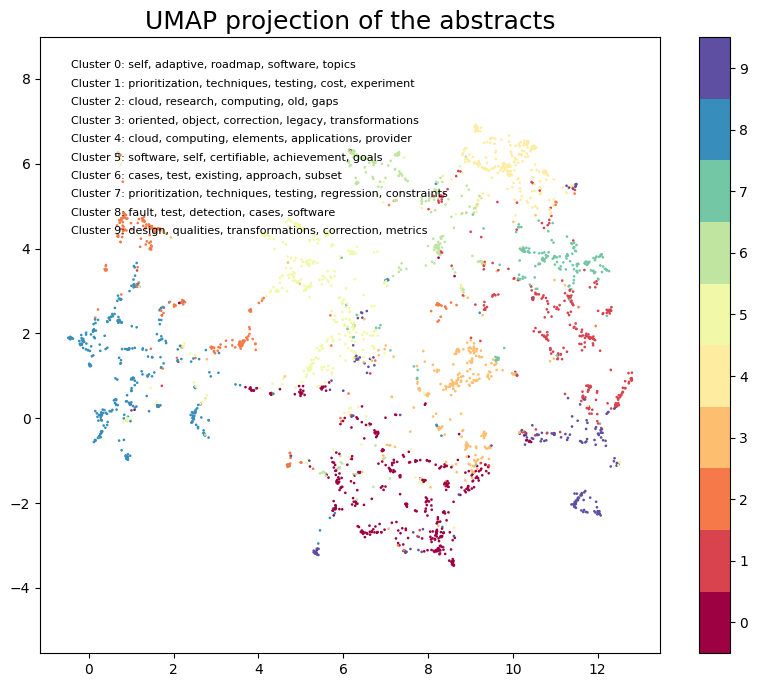

In [75]:
plt.figure(figsize=(10, 8))
plt.scatter(umap_embeddings[:, 0], umap_embeddings[:, 1], 
            c=combined_df['cluster'], s=0.8, cmap='Spectral')

# legend for clusters (keywords)
for i in range(num_clusters):
    keywords = (top_keywords[i])
    keywords = ', '.join(keywords)
    plt.text(0.05, 0.95-i*0.03, f"Cluster {i}: {keywords}", fontsize=8, transform=plt.gca().transAxes)
                # bbox=dict(facecolor='white', alpha=0.8, edgecolor=plt.cm.Spectral(i / float(num_clusters))), va='top')


plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the abstracts', fontsize=18)
plt.colorbar(boundaries=np.arange(num_clusters+1)-0.5).set_ticks(np.arange(num_clusters))


plt.show()

In [120]:
import plotly.express as px
import plotly.colors as pcolors
colors = pcolors.qualitative.D3   


# combined_df['cluster'] = combined_df['cluster'].astype(str)
combined_df_pubdate['cluster'] = combined_df_pubdate['cluster'].astype(str)

fig = px.scatter(combined_df_pubdate,
                 x="umap_x", y="umap_y", 
                 color="cluster",
                 color_discrete_sequence=colors,
                 hover_data=['title', 'first_name', 'department', 'faculty'], 
                 opacity=0.7,
                 width=1000, height=800)


for i in range(num_clusters):       
    keywords = (top_keywords[i])[:5]
    keywords = ', '.join(keywords)
    fig.add_annotation(x=0.05, y=8.95-i*0.33, text=f"Cluster {i}: {keywords}", showarrow=False, font=dict(size=13))
    

fig.show()

In [118]:
import plotly.express as px

# cluster to string
combined_df['cluster'] = combined_df['cluster'].astype(str)

fig = px.scatter(combined_df, 
                 x="umap_x", y="umap_y", 
                 color="department_broad",
                    color_discrete_sequence=colors,
                     
                 hover_data=['title', 'first_name', 'department', 'faculty', 'focus_tag'], 
                 opacity=0.7,
                 width=1200, height=800)


# add legend for clusters (keywords)
for i in range(num_clusters):
    keywords = (top_keywords[i])[:5]
    keywords = ', '.join(keywords)
    fig.add_annotation(x=0.05, y=8.95-i*0.33, text=f"Cluster {i}: {keywords}", showarrow=False, font=dict(size=13))
    

fig.show()

In [78]:
# correlation between cluster, faculty, department

corr = combined_df[['cluster', 'faculty', 'department', 'department_broad', 'focus_tag']].apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1).round(decimals=2)
corr.style.background_gradient(cmap='coolwarm')

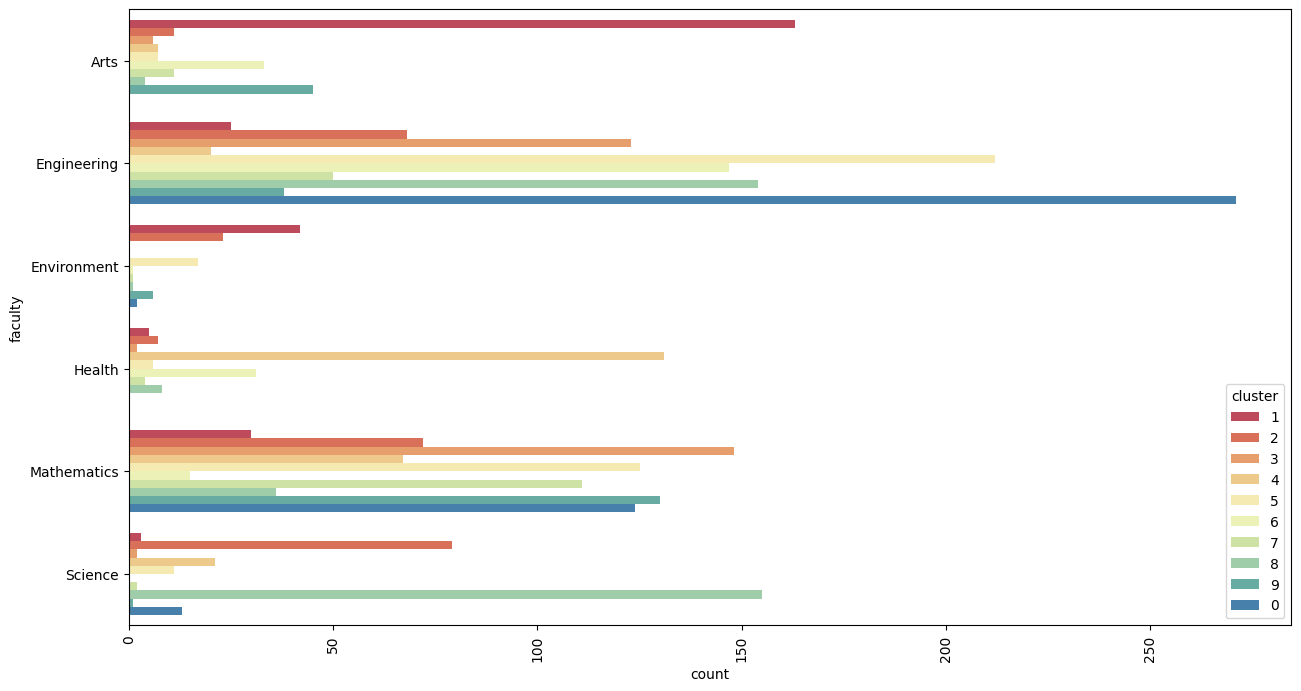

In [85]:
# bar chart showing the number of papers for each professor in each cluster

# count the number of papers for each professor in each cluster
professor_cluster_counts = combined_df.groupby(['faculty', 'cluster']).size().reset_index(name='count')

# sns plot
plt.figure(figsize=(15, 8))
sns.barplot(x='count', y='faculty', hue='cluster', data=professor_cluster_counts, palette='Spectral')
plt.xticks(rotation=90)
plt.show()